In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata  # Importo griddata
import cmocean #colori per oceanografia
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap

#definition of the file path
file_path = "C:/Users/Marta/OneDrive/Documenti/UniTs/2_anno/Tirocinio/data/PS118_phys_oce.tab"

#load the data 
df1 = pd.read_csv(file_path, skiprows=4797, nrows=13981, sep='\t')
#data contains the oceanographic data in table form 

#rename the columns
df1.columns = ['Event', 'Date/Time', 'Latitude', 'Longitude', 'Elevation_m', 
               'Depth_m', 'Pressure_dbar',
               'Temperature_C', 'Conductivity_mS_cm', 'Salinity', 'Tpot_C', 
               'Sigma_theta', 'O2', 'O2_sat', 'Attenuation', 'Fluorometer', 'NOBS']

#drop the last 3 columns (by selecting column names)
#data.columns returns a list of all column names; [] it selects only the last 3 
#columns_to_drop contains the names of the last 3 columns i want to remove
columns_to_drop = df1.columns[-3:]

data = df1.drop(columns=columns_to_drop)
#data is updated. Last 3 columns ahve been excluded

#convert the "Date/Time" column to datetime format
data['Date/Time'] = pd.to_datetime(data['Date/Time'])

#create separate "Date" and "Time" columns
data['Date'] = data['Date/Time'].dt.date
data['Time'] = data['Date/Time'].dt.time

#drop the original "Date/Time" column if not needed
data = data.drop(columns=['Date/Time'])


#reorder columns to place 'Date' and 'Time' after 'Event'
data = data[['Event', 'Date', 'Time', 'Latitude', 'Longitude', 'Elevation_m', 
             'Depth_m', 'Pressure_dbar', 'Temperature_C', 'Conductivity_mS_cm', 
             'Salinity', 'Tpot_C', 'Sigma_theta', 'O2', 'O2_sat']]

#print(data.head())
#print(data.tail())

In [2]:
#plt.plot(long,'*')

#verifico i mini e i massimi dei dati
#print(np.max(p))
#print(np.max(Tpot))
#print(np.min(Tpot))
#print(np.max(Salinity))
#print(np.min(Salinity))
#print(np.nanmin(sigma_theta))
#print(np.nanmax(sigma_theta)) 

In [3]:
#grid
#meridional averaging
data_mer_av = data.groupby(['Pressure_dbar', 'Longitude'])[['Tpot_C', 'Salinity', 'Sigma_theta', 'O2', 'O2_sat']].mean().reset_index()

#extract variables
long = data_mer_av['Longitude'].values
p = data_mer_av['Pressure_dbar'].values
Tpot = data_mer_av['Tpot_C'].values
Salinity = data_mer_av['Salinity'].values
sigma_theta = data_mer_av['Sigma_theta'].values  
O2 = data_mer_av['O2'].values
O2_sat = data_mer_av['O2_sat'].values

#AOU
AOU = (O2_sat - O2)

#structured grid
longgrid = np.array([-53.8027, -53.6639, -53.5333, -53.3744, -53.1500, -52.8898, -52.6662, -52.3943])
pgrid = np.linspace(p.min(), p.max(), 3000)  
long_grid, p_grid = np.meshgrid(longgrid, pgrid)

#interpolation in grid
valid_data = ~np.isnan(long) & ~np.isnan(p) & ~np.isnan(Tpot) & ~np.isnan(Salinity) & ~np.isnan(sigma_theta) & ~np.isnan(AOU) & ~np.isnan(O2)
points = np.vstack((long[valid_data], p[valid_data])).T

grid_Tpot = griddata((long, p), Tpot, (long_grid, p_grid), method='cubic')
grid_Salinity = griddata((long, p), Salinity, (long_grid, p_grid), method='cubic')
grid_sigma_theta = griddata((long, p), sigma_theta, (long_grid, p_grid), method='linear')
grid_AOU = griddata((long, p), AOU, (long_grid, p_grid), method='cubic')
grid_O2 = griddata((long, p), O2, (long_grid, p_grid), method='cubic')

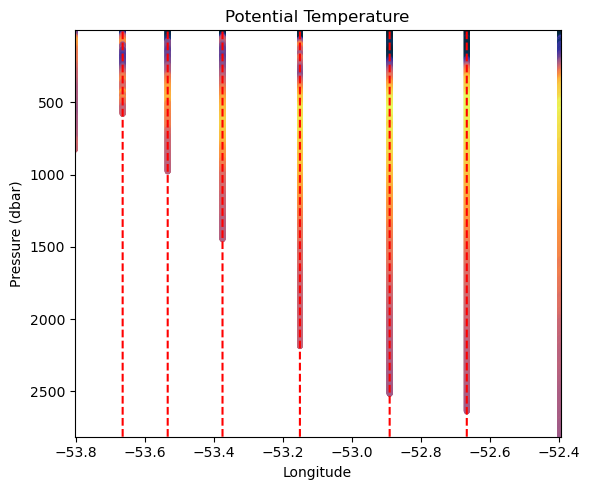

In [4]:
#scatter plot
fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(long, p, c=Tpot, cmap='cmo.thermal', vmin=-1.75, vmax=0.65, s=10)
ax.set_xlabel('Longitude')
ax.set_ylabel('Pressure (dbar)')
ax.set_title('Potential Temperature')
ax.contour(long_grid, p_grid, long_grid, levels=long_grid[0,:], colors='red')

ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [5]:
#verifico le max p per ogni longitude dei miei dati
max_pressure = {}
for lon_target in longgrid:
    subset = data[np.isclose(data['Longitude'], lon_target, atol=1e-4)]
    if not subset.empty:
        max_pressure[lon_target] = subset['Pressure_dbar'].max()
        print(f"Max pressure at longitude {lon_target}: {max_pressure[lon_target]} dbar")

Max pressure at longitude -53.8027: 829 dbar
Max pressure at longitude -53.6639: 581 dbar
Max pressure at longitude -53.5333: 979 dbar
Max pressure at longitude -53.3744: 1448 dbar
Max pressure at longitude -53.15: 2188 dbar
Max pressure at longitude -52.8898: 2518 dbar
Max pressure at longitude -52.6662: 2639 dbar
Max pressure at longitude -52.3943: 2814 dbar


In [6]:
#masking
#start with a blank mask
full_mask = np.zeros_like(long_grid, dtype=bool)

for j, lon_col in enumerate(longgrid):
    max_p = max_pressure.get(lon_col, 0) # Get max pressure, default to 0 if not found
    if max_p > 0: # Only mask if we have a valid max pressure
        # Mask grid points in this column (j) where pressure > max_p
        full_mask[:, j] = p_grid[:, j] > max_p

# Apply the full mask to all variables
grid_Tpot[full_mask] = np.nan
grid_Salinity[full_mask] = np.nan
grid_sigma_theta[full_mask] = np.nan
grid_O2[full_mask] = np.nan
grid_AOU[full_mask] = np.nan

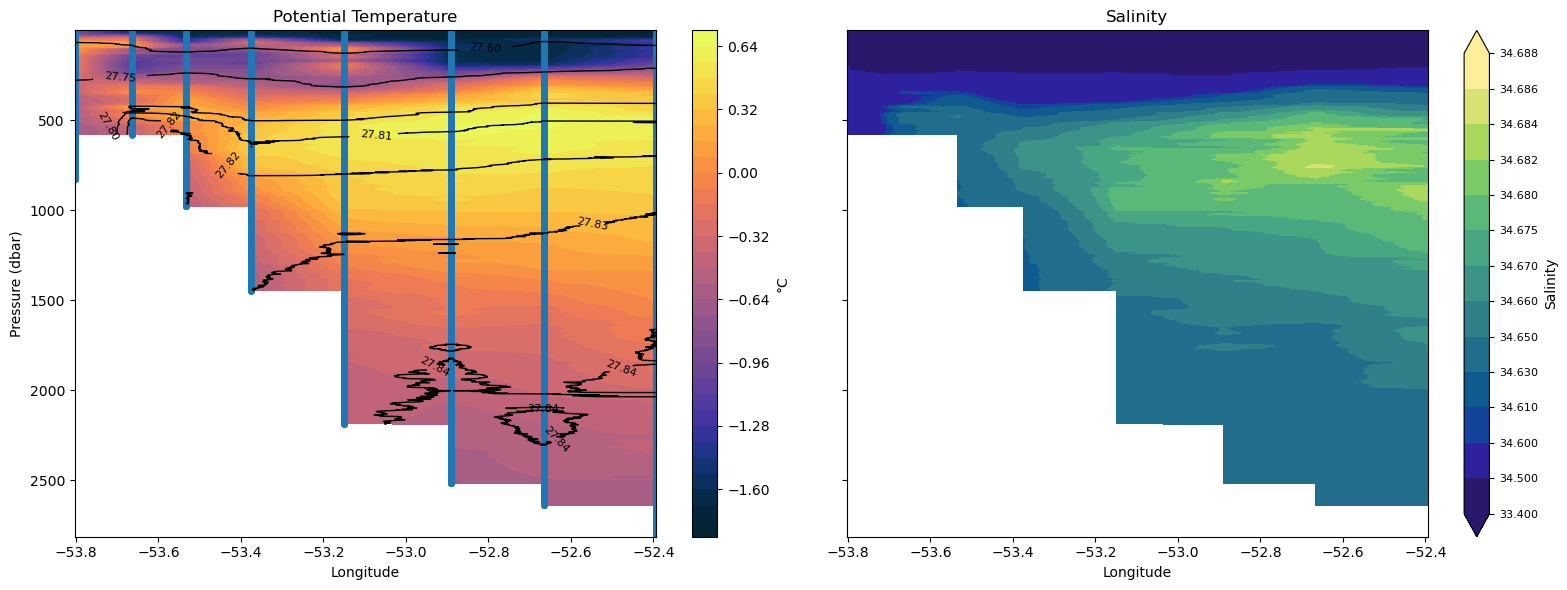

In [7]:
#side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

#plot 1: potential temperature
cntr1 = ax1.contourf(long_grid, p_grid, grid_Tpot, levels=30, cmap='cmo.thermal', vmin=-1.75, vmax=0.65)
#sc1 = ax1.scatter(long, p, c=Tpot, cmap='cmo.thermal', vmin=-1.2, vmax=0.5, s=10)
sc = ax1.scatter(long, p, s=15)
#sc_1 = ax1.scatter(long[0:-1:100], p[0:-1:100], c=Tpot[0:-1:100], vmin=-1, vmax=0.3, edgecolors='k')
#ax1.contour(long_grid, p_grid, long_grid, levels=long_grid[0,:], colors='red')

cb1 = plt.colorbar(cntr1, ax=ax1)
cb1.set_label('°C')

#density isolines
sigma_theta_bounds = [26.8, 27.6, 27.75, 27.80, 27.81, 27.82, 27.83, 27.84, 27.85]
intervals =len(sigma_theta_bounds)-1
contours1 = ax1.contour(long_grid, p_grid, grid_sigma_theta, levels=sigma_theta_bounds, colors='black', linewidths=1)
ax1.clabel(contours1, inline=True, fmt='%0.2f', fontsize=8)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('Potential Temperature')

#plot 2: salinity
bounds = [33.40, 34.50, 34.60, 34.61, 34.63, 34.65, 34.66, 34.67, 34.675, 34.68, 34.682, 34.684, 34.686, 34.688]
num_intervals = len(bounds)-1
cmap = plt.get_cmap('cmo.haline', num_intervals)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

cntr2 = ax2.contourf(long_grid, p_grid, grid_Salinity, levels=bounds, cmap=cmap, norm=norm, extend='both')
#sc2 = ax2.scatter(long, p, cmap=cmap, norm=norm, s=15)
#sc_2 = ax2.scatter(long[0:-1:100], p[0:-1:100], c=Salinity[0:-1:100], vmin=34.48, vmax=34.72, edgecolors='k')

cb2 = fig.colorbar(cntr2, ax=ax2, norm=norm, boundaries=bounds, ticks=bounds, label='Salinity')
cb2.ax.tick_params(labelsize=8)

ax2.set_xlabel('Longitude')
ax2.set_title('Salinity')
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

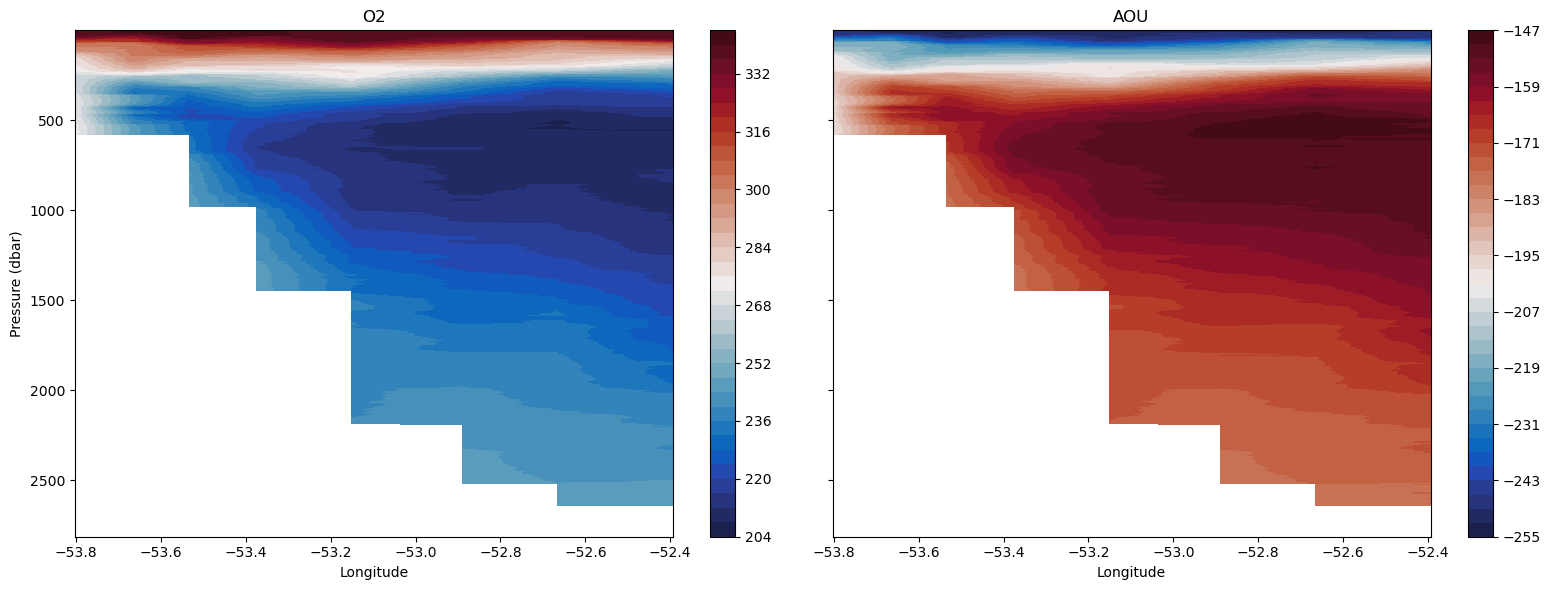

In [8]:
#O2, AOU
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

#plot 1: O2
cntr1 = ax1.contourf(long_grid, p_grid, grid_O2, levels=35, cmap='cmo.balance')
c1 = plt.colorbar(cntr1, ax=ax1)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('O2')


#plot 2: AOU (apparent oxygen utilisation)
cntr2 = ax2.contourf(long_grid, p_grid, grid_AOU, levels=35, cmap='cmo.balance') 
c2 = plt.colorbar(cntr2, ax=ax2)

ax2.set_xlabel('Longitude')
ax2.set_title('AOU')
ax1.invert_yaxis()
plt.tight_layout()
plt.show()